<a href="https://colab.research.google.com/github/phitonthel/Assignment-05-W05/blob/master/Bangkit_Assignment_05_W05_First_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"phitonthel","key":"d9ea2b50c6ed0d87faec6a6446db15dd"}'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
!kaggle datasets list



-rw-r--r-- 1 root root 66 Jul  3 13:38 kaggle.json
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-29 17:04:40          85057  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          14729  
madeleineferguson/farmers-markets-in-the-united-states      Farmers Markets in the United States                816KB  2020-06-10 16:41:46            800  
promptcloud/jobs-on-naukricom                               Jobs On Naukri.com                                    3MB  2020-06-15 10:51:07            845  
mikahama/the-

In [4]:
# Download the Kaggle Dataset
!kaggle datasets download -d luisblanche/covidct

covidct.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
base_dir = '/content'
data_dir = os.path.join(base_dir, 'data')
local_zip = os.path.join(base_dir, 'covidct.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
os.mkdir(data_dir)
zip_ref.extractall(data_dir)
zip_ref.close()

FileExistsError: ignored

In [7]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
os.mkdir(train_dir)
os.makedirs(os.path.join(test_dir, 'CT_COVID'))
os.mkdir(os.path.join(test_dir, 'CT_NonCOVID'))

FileExistsError: ignored

In [8]:
import random
import math
import shutil

train_portion = .50

def splitter(name):
  data_path = os.path.join(data_dir, name)
  temp = os.listdir(data_path)
  split = math.floor(len(temp) * train_portion)

  test_tmp = temp[split:]

  for i in test_tmp:
    shutil.move(os.path.join(data_path, i), os.path.join(test_dir, name, i))
  
  shutil.move(data_path, train_dir)

splitter('CT_COVID')
splitter('CT_NonCOVID')

FileNotFoundError: ignored

In [9]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    )
     
test_datagen = ImageDataGenerator(
    rescale=1./255
    )

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='binary',
  batch_size= 61
)

test_generator = test_datagen.flow_from_directory(
	test_dir,
	target_size=(150,150),
	class_mode='binary',
  batch_size=25
)

Found 372 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [10]:
class AccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .9:
      self.model.stop_training = True

In [11]:
from tensorflow.keras.optimizers import RMSprop

# DEFINE A KERAS MODEL TO CLASSIFY COVID V NONCOVID
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [12]:
history = model.fit(train_generator, epochs=100, steps_per_epoch=3, validation_data = test_generator, verbose = 1, validation_steps=3,
                    # callbacks=[AccCallback()]
                    )

Epoch 1/100
3/3 [==============================] - 1s 407ms/step - loss: 7.9159 - accuracy: 0.5246 - val_loss: 0.8379 - val_accuracy: 0.6400
Epoch 2/100
3/3 [==============================] - 1s 320ms/step - loss: 0.8527 - accuracy: 0.5082 - val_loss: 0.6992 - val_accuracy: 0.4933
Epoch 3/100
3/3 [==============================] - 1s 360ms/step - loss: 0.6797 - accuracy: 0.5410 - val_loss: 0.7708 - val_accuracy: 0.5600
Epoch 4/100
3/3 [==============================] - 1s 357ms/step - loss: 0.6202 - accuracy: 0.6641 - val_loss: 0.6046 - val_accuracy: 0.6533
Epoch 5/100
3/3 [==============================] - 1s 367ms/step - loss: 0.9597 - accuracy: 0.6284 - val_loss: 0.7911 - val_accuracy: 0.5200
Epoch 6/100
3/3 [==============================] - 1s 393ms/step - loss: 0.7464 - accuracy: 0.5156 - val_loss: 0.6554 - val_accuracy: 0.5467
Epoch 7/100
3/3 [==============================] - 1s 372ms/step - loss: 0.6079 - accuracy: 0.6393 - val_loss: 0.6281 - val_accuracy: 0.6267
Epoch 8/100
3

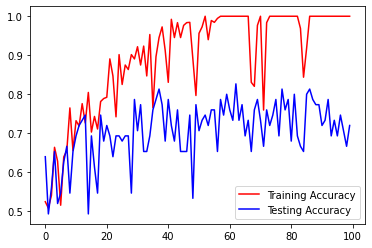

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Testing Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

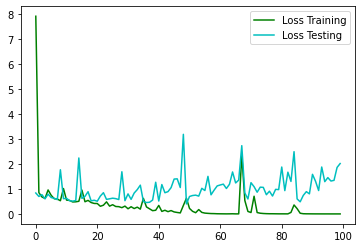

<Figure size 432x288 with 0 Axes>

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, loss, 'g', label='Loss Training')
plt.plot(epochs, val_loss, 'c', label='Loss Testing')
plt.legend(loc=0)
plt.figure()
plt.show()